In [147]:
!pip install --quiet wikipedia==1.4.0 langchain-core==0.3.59 langgraph==0.5.3 langchain-openai==0.3.16 langchain-experimental==0.3.4 pydantic==2.11.9 python-dotenv==1.0.1 requests==2.31.0
!pip install rapidfuzz
!pip install tabulate


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for tabulate from https://files.pythonhosted.org/packages/40/44/4a5f08c96eb108af5cb50b41f76142f0afa346dfa99d5296fe7202a11854/tabulate-0.9.0-py3-none-any.whl.metadata

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import requests
import json

link = 'https://fantasy.premierleague.com/api/bootstrap-static/'

data = json.loads(requests.get(link).text)

In [3]:
from typing import Annotated
from langchain_core.tools import tool
import pandas as pd
import os
from dotenv import load_dotenv

@tool
def team_data(team_name: Annotated[str, "The name of the English Premier League Team's stats for the current season to look up."]) -> str:
    """
    Use this to look-up latest football team-level performance data for teams in the English Premier League (EPL).

    leave team_name blank to get data for all teams. Do this by passing an empty string ("") as the team_name. Try doing this if I don't specify a team. 
    If I ask for a ranking of teams, you should first get data for all teams, then rank them accordingly and make sure that the ranking is correct. 
    Double check your work if needed. Don't output false rankings and only output it if you're sure it's correct and accurate.

    The fields strength_overall_home, strength_overall_away, strength_attack_home, strength_attack_away,
    strength_defence_home, and strength_defence_away are all ratings between 1000 and 1400 that indicate how strong a team is in those areas.
    1000 is the worst possible rating and 1400 is the best possible rating.
    """
    team_data = data['teams']
    df = pd.DataFrame(team_data)
    df = df.drop(columns=['code', 'draw', 'form', 'id', 'loss', 'played', 'points', 'strength', 'team_division', 'unavailable', 'win'])
    
    if team_name.strip() == "":
        return df.to_markdown()
    
    team_info = df[df['name'].str.lower() == team_name.lower()]
    if team_info.empty:
        return f"No data found for team: {team_name}"
    return team_info.to_markdown()

@tool
def get_player_name_from_id(player_id: Annotated[int, "The ID of the English Premier League Player whose name you want to look up."]) -> str:
    """
    Use this to look-up the name of a player in the English Premier League (EPL) given their player ID.
    """
    player_data = data['elements']
    df = pd.DataFrame(player_data)
    player_info = df[df['id'] == player_id]
    if player_info.empty:
        return f"No data found for player ID: {player_id}"
    player_name = f"{player_info.iloc[0]['first_name']} {player_info.iloc[0]['second_name']}"
    return player_name

@tool
def fpl_gw_info(gw_number: Annotated[int, "The fpl gameweek number to look up information for."]) -> str:
    """
    Use this to look-up latest information about a specific gameweek in the English Premier League (EPL).
    """
    events_data = data['events']
    df = pd.DataFrame(events_data)
    gw_info = df[df['id'] == gw_number]
    if gw_info.empty:
        return f"No data found for gameweek: {gw_number}"
    return gw_info.to_markdown()

@tool
def fpl_scoring_rules() -> str:
    """
    Use this to look-up the latest scoring rules for the English Premier League (EPL) fantasy football game.
    long_play: player played 60 or more minutes
    short_play: player played less than 60 minutes
    """
    scoring_data = data['game_config']['scoring']
    df = pd.DataFrame(scoring_data)
    return df.to_markdown()

@tool
def player_types() -> str:
    """
    Use this to look-up the different player types/positions in the English Premier League (EPL) fantasy football game.
    """
    element_types_data = data['element_types']
    df = pd.DataFrame(element_types_data)
    return df.to_markdown()

@tool 
def my_fpl_team_players(
            user_id: Annotated[int, "The user's fantasy premier league team ID to look up information for."],
            gw: Annotated[int, "FPL Gameweek number. Must be between 1 and 38. Unless specified otherwise, use the most recent gameweek that is on-going or has just ended."]) -> str:
    """
    Use this to look-up the players in a user's fantasy premier league team for a specific gameweek.
    """
    url = f'https://fantasy.premierleague.com/api/entry/{user_id}/event/{gw}/picks/'
    response = requests.get(url)
    team_data = json.loads(response.text)
    team_data = team_data['picks']
    df = pd.json_normalize(team_data)
    return df.to_markdown()



from langchain_experimental.utilities import PythonREPL

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user. The chart should be displayed using `plt.show()`."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed the Python REPL tool.\n\nPython code executed:\n\`\`\`python\n{code}\n\`\`\`\n\nCode output:\n\`\`\`\n{result}\`\`\`"

In [4]:
data.keys()

dict_keys(['chips', 'events', 'game_settings', 'game_config', 'phases', 'teams', 'total_players', 'element_stats', 'element_types', 'elements'])

In [5]:
data['elements']

[{'can_transact': True,
  'can_select': True,
  'chance_of_playing_next_round': None,
  'chance_of_playing_this_round': None,
  'code': 154561,
  'cost_change_event': 0,
  'cost_change_event_fall': 0,
  'cost_change_start': 4,
  'cost_change_start_fall': -4,
  'dreamteam_count': 1,
  'element_type': 1,
  'ep_next': '5.0',
  'ep_this': '5.0',
  'event_points': 6,
  'first_name': 'David',
  'form': '4.0',
  'id': 1,
  'in_dreamteam': False,
  'news': '',
  'news_added': None,
  'now_cost': 59,
  'photo': '154561.jpg',
  'points_per_game': '4.1',
  'removed': False,
  'second_name': 'Raya Martín',
  'selected_by_percent': '33.2',
  'special': False,
  'squad_number': None,
  'status': 'a',
  'team': 1,
  'team_code': 3,
  'total_points': 99,
  'transfers_in': 3534649,
  'transfers_in_event': 18902,
  'transfers_out': 2016060,
  'transfers_out_event': 6450,
  'value_form': '0.7',
  'value_season': '16.8',
  'web_name': 'Raya',
  'region': 200,
  'team_join_date': '2024-07-04',
  'birth_dat

In [6]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)
load_dotenv()

tools = [team_data, python_repl_tool, fpl_gw_info, fpl_scoring_rules, player_types, my_fpl_team_players, get_player_name_from_id]

llm = ChatOpenAI(model="gpt-4o-mini", base_url='https://openrouter.ai/api/v1', openai_api_key=os.getenv('OPENAI'))
# Tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def llm_node(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [7]:
from langgraph.prebuilt import ToolNode, tools_condition

# Create the llm and tools nodes
graph_builder.add_node("llm", llm_node)


tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# Add the edges
graph_builder.add_edge(START, "llm")
graph_builder.add_conditional_edges("llm", tools_condition, ['tools', END])
graph_builder.add_edge("tools", "llm") 

graph = graph_builder.compile()

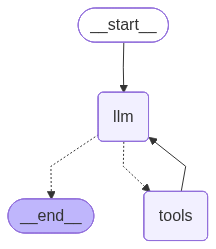

In [8]:
# Visualize your graph
graph

In [9]:
from IPython.display import Markdown, display

def print_stream(stream):
    for chunk in stream:
        for node, data in chunk.items():
            print(f"\n{'='*50}\nNode: {node}\n{'='*50}")
            
            if "messages" in data:
                # Get the last message in the chunk
                message = data["messages"][-1]
                
                # If it's an AI Message with content (the final answer)
                if hasattr(message, "content") and message.content:
                    display(Markdown(message.content))
                
                # If it's a Tool Call (showing the intent)
                if hasattr(message, "tool_calls") and message.tool_calls:
                    for tool in message.tool_calls:
                        print(f"🛠️  Calling Tool: {tool['name']} with args: {tool['args']}")
                
                # If it's a Tool Message (the result of the search)
                if node == "tools":
                    # Display the table properly
                    display(Markdown(message.content))

In [ ]:
inputs = {"messages": [("user", "Give me top 3 teams in the English Premier League based on their overall home strength.")]}
print_stream(graph.stream(inputs, stream_mode="updates"))

NameError: name 'print_stream' is not defined